<a href="https://colab.research.google.com/github/Dayaanaly/BioKnee/blob/Dayana/Modelo_pre_entrenado_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelo preentrenado U-Net BioKnee**

In [5]:
from tensorflow.keras.models import load_model

# Montar Drive si no lo has hecho ya
from google.colab import drive
drive.mount('/content/drive')

# Ruta al modelo guardado
model_path = '/content/drive/MyDrive/Equipo Trifuerza/Códigos fuentes/Modelos entrenados/U-Net_entrenada_5ep.h5'

# Cargar el modelo
model = load_model(model_path)
print("Modelo cargado correctamente.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Modelo cargado correctamente.


In [6]:
!pip install pynrrd

In [7]:
import os
import numpy as np
import cv2
import nrrd
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Rutas a las imágenes y máscaras
image_dir = '/content/drive/MyDrive/Equipo Trifuerza/Datos/Data set grises/Dataset mascaras 2D/'
mask_dir  = '/content/drive/MyDrive/Equipo Trifuerza/Datos/Data set grises/Mascaras-2D/'

IMG_HEIGHT = 320
IMG_WIDTH = 224
IMG_CHANNELS = 1
NUM_CLASSES = 4

valid_extensions = ('.nrrd', '.bmp')
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(valid_extensions)])
mask_files  = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(valid_extensions)])

def load_image_custom(filepath, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale'):
    ext = os.path.splitext(filepath)[1].lower()
    if ext == '.nrrd':
        img_data, _ = nrrd.read(filepath)
        if color_mode == 'grayscale':
            if img_data.ndim == 3 and img_data.shape[-1] > 1:
                img_data = np.mean(img_data, axis=-1)
            img_resized = cv2.resize(img_data, (target_size[1], target_size[0]))
            img_resized = np.expand_dims(img_resized, axis=-1)
            return img_resized
    else:
        return img_to_array(load_img(filepath, target_size=target_size, color_mode=color_mode))

images = []
masks = []

for img_file, msk_file in zip(image_files, mask_files):
    image_path = os.path.join(image_dir, img_file)
    mask_path  = os.path.join(mask_dir, msk_file)

    img = load_image_custom(image_path)
    img = img.astype('float32') / 255.0
    mask = load_image_custom(mask_path)
    mask = np.rot90(mask, k=1, axes=(0, 1))
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask.astype(np.int64), axis=-1)

    images.append(img)
    masks.append(mask)

images = np.array(images)
masks = np.array(masks)

# Dividir en validación
from sklearn.model_selection import train_test_split
_, images_val, _, masks_val = train_test_split(images, masks, test_size=0.1, random_state=42)


In [9]:
predictions = model.predict(images_val)
predicted_masks = np.argmax(predictions, axis=-1)
predicted_masks = np.expand_dims(predicted_masks, axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step


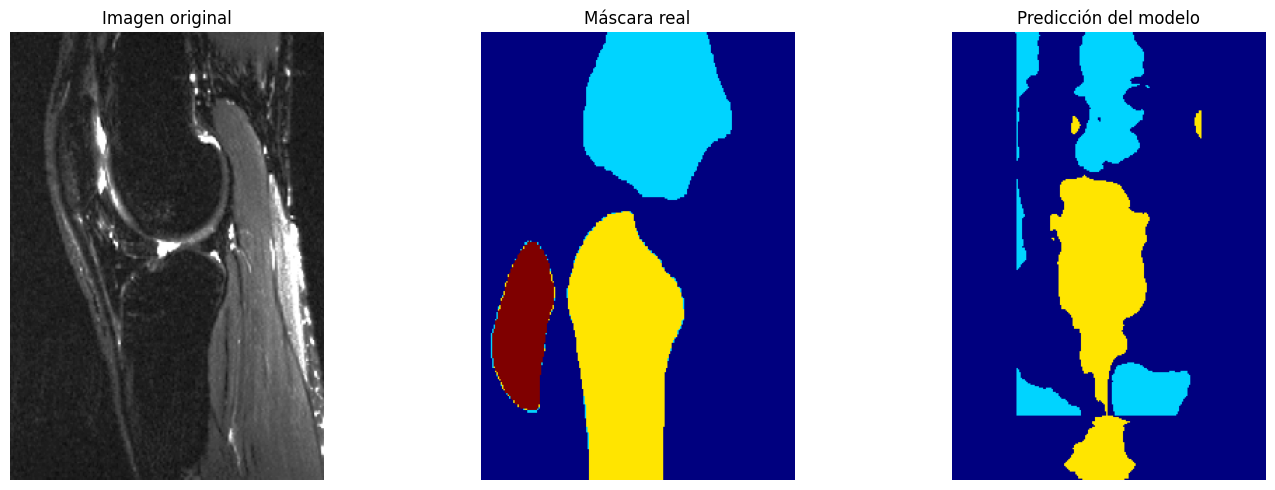

In [10]:
import matplotlib.pyplot as plt
import random

i = random.randint(0, len(images_val) - 1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(images_val[i].squeeze(), cmap='gray')
plt.title("Imagen original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(masks_val[i].squeeze(), cmap='jet', vmin=0, vmax=NUM_CLASSES - 1)
plt.title("Máscara real")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_masks[i].squeeze(), cmap='jet', vmin=0, vmax=NUM_CLASSES - 1)
plt.title("Predicción del modelo")
plt.axis('off')

plt.tight_layout()
plt.show()
